# Import the Data

In [1]:
import unicodedata
import glob
import os
import string
import torch
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

all_letters = string.ascii_letters + " .,;'"

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of names per language
lang_names = {}

def findFiles(path): return glob.glob(path)

for filename in findFiles('../data/names/*.txt'):
    lang = os.path.splitext(os.path.basename(filename))[0]
    names = readLines(filename)
    lang_names[lang] = names

# Encode data into numerical tensors

In [2]:
idx2char = dict(enumerate(list(all_letters) + ["<EOS>"]))

In [3]:
char2idx = {j:i for i,j in idx2char.items()}

In [4]:
n_vocab = len(idx2char.keys())

In [5]:
langs = list(lang_names.keys())

In [6]:
idx2lang = dict(enumerate(langs))

In [7]:
lang2idx = {j:i for i,j in idx2lang.items()}

In [8]:
n_langs = len(langs)

In [9]:
def langToTensor(lang):
    tensor = torch.zeros(n_langs)
    tensor[lang2idx[lang]] = 1
    return tensor

In [10]:
def nameToTensor(name):
    tensor = torch.zeros(len(name), n_vocab)

    for i, char in enumerate(name):
        tensor[i][char2idx[char]] = 1
    return tensor

In [11]:
def nameToTarget(name):
    name = list(name) + ["<EOS>"]
    tensor = [char2idx[i] for i in name]
    tensor = tensor[1:]
    tensor = torch.tensor(tensor)
    return tensor

# Define the Neural Network

In [12]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size + n_langs, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size + n_langs, output_size)
        self.o2o = nn.Linear(output_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 0)
    
    def forward(self, input, hidden, lang):
        combined = torch.cat([input, hidden, lang])
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        combined_output = torch.cat([hidden, output])
        output = self.o2o(combined_output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(self.hidden_size)

In [13]:
langs = list(lang_names.keys())

In [14]:
n_langs = len(langs)

In [15]:
n_hidden = 128

In [16]:
rnn = RNN(input_size = n_vocab, hidden_size = n_hidden, output_size = n_vocab)

# Pass an example through our Neural Network

In [17]:
name = "Smith"
name_tensor = nameToTensor(name)
lang = "English"
lang_tensor = langToTensor(lang)
target = nameToTarget(name)

In [18]:
hidden = rnn.initHidden()

In [19]:
output, hidden = rnn(name_tensor[0], hidden, lang_tensor)

In [20]:
output, hidden = rnn(name_tensor[1], hidden, lang_tensor)

In [21]:
criterion = nn.NLLLoss()

In [22]:
output

tensor([-4.0576, -4.1108, -4.1347, -4.0549, -4.0846, -4.0762, -4.1781, -3.9412,
        -3.9231, -4.1609, -4.0049, -4.0174, -3.9572, -3.9181, -4.0378, -4.1057,
        -4.0539, -4.0511, -4.0650, -4.0987, -4.1339, -4.2165, -4.0419, -4.1481,
        -4.0834, -4.0556, -4.1387, -4.1370, -3.9936, -4.0773, -4.0216, -3.9261,
        -3.9859, -4.0089, -4.1286, -4.1321, -3.9802, -4.0828, -4.1310, -4.1619,
        -4.1531, -4.1782, -3.9518, -4.0287, -4.1153, -4.1192, -4.0752, -4.1033,
        -4.1271, -4.1491, -4.1394, -3.9787, -3.9808, -3.9511, -4.0771, -3.9696,
        -3.9472, -4.0104], grad_fn=<LogSoftmaxBackward0>)

In [23]:
loss = criterion(output, target[1])

In [24]:
loss

tensor(3.9231, grad_fn=<NllLossBackward0>)

# Train our NN

In [25]:
def randomExample():
    lang = random.sample(langs, 1)[0]
    name = random.sample(lang_names[lang], 1)[0]
    return lang, name

In [26]:
n_iters = 100000
learning_rate = 0.005

all_losses = []

avg_loss = 0
n_checkpoint = 1000
for i in range(1, n_iters + 1):
    
    # Initialize hidden state
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    lang, name = randomExample()
    
    input = nameToTensor(name)
    lang_tensor = langToTensor(lang)
    target = nameToTarget(name)
    
    loss = torch.Tensor([0])
    for j in range(input.size()[0]):
        output, hidden = rnn(input[j], hidden, lang_tensor)
        l = criterion(output, target[j])
        loss += l
    
    loss.backward()
    
    loss /= input.size()[0]
    
    avg_loss += loss
        
    if i % n_checkpoint == 0:
        avg_loss /= n_checkpoint
        print("Iterations: ", i)
        print("Average loss: ", round(avg_loss.item(), 4))
        
        all_losses.append((i, round(avg_loss.item(), 4)))
        
        avg_loss = 0
    
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)

Iterations:  1000
Average loss:  2.943
Iterations:  2000
Average loss:  2.634
Iterations:  3000
Average loss:  2.4685
Iterations:  4000
Average loss:  2.4303
Iterations:  5000
Average loss:  2.3475
Iterations:  6000
Average loss:  2.2893
Iterations:  7000
Average loss:  2.3009
Iterations:  8000
Average loss:  2.2223
Iterations:  9000
Average loss:  2.241
Iterations:  10000
Average loss:  2.2154
Iterations:  11000
Average loss:  2.2233
Iterations:  12000
Average loss:  2.2099
Iterations:  13000
Average loss:  2.1868
Iterations:  14000
Average loss:  2.161
Iterations:  15000
Average loss:  2.1644
Iterations:  16000
Average loss:  2.1616
Iterations:  17000
Average loss:  2.1536
Iterations:  18000
Average loss:  2.1447
Iterations:  19000
Average loss:  2.1448
Iterations:  20000
Average loss:  2.1277
Iterations:  21000
Average loss:  2.1217
Iterations:  22000
Average loss:  2.0897
Iterations:  23000
Average loss:  2.1298
Iterations:  24000
Average loss:  2.1147
Iterations:  25000
Average lo

# Plot the learning curve

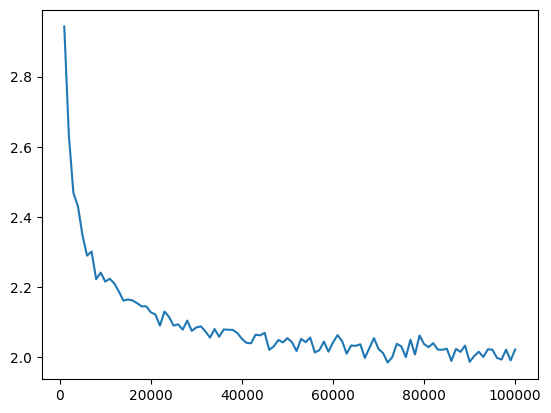

In [27]:
plt.figure()
plt.plot([x[0] for x in all_losses], [x[1] for x in all_losses])

# Evaluating on some inputs

In [28]:
def predict(starting_letters, lang):
    predicted_name = starting_letters

    hidden = rnn.initHidden()
    lang_tensor = langToTensor(lang)
    for i in range(len(starting_letters)):
        input = nameToTensor(starting_letters[i])[0]
        output, hidden = rnn(input, hidden, lang_tensor)

    val, idx = output.topk(3, 0, True)
    next_letter = idx2char[idx[0].item()]
    
    if next_letter == "<EOS>":
        return predicted_name
            
    predicted_name += next_letter
    input = nameToTensor(next_letter)[0]

    max_length = 20
    for i in range(len(starting_letters), max_length):
        output, hidden = rnn(input, hidden, lang_tensor)

        val, idx = output.topk(3, 0, True)
        next_letter = idx2char[idx[0].item()]

        if next_letter == "<EOS>":
            break
        else:
            predicted_name += next_letter
            input = nameToTensor(next_letter)[0]
    return predicted_name

In [29]:
letters = "Filip"
print("Starting Letters: ", letters)
for lang in langs:
    print("Language: ", lang)
    predicted_name = predict(starting_letters = letters, lang = lang)
    print("Predicted Name: ", predicted_name)
    print()

Starting Letters:  Filip
Language:  Czech
Predicted Name:  Filip

Language:  German
Predicted Name:  Filip

Language:  Arabic
Predicted Name:  Filip

Language:  Japanese
Predicted Name:  Filipa

Language:  Chinese
Predicted Name:  Filip

Language:  Vietnamese
Predicted Name:  Filip

Language:  Russian
Predicted Name:  Filiph

Language:  French
Predicted Name:  Filip

Language:  Irish
Predicted Name:  Filipha

Language:  English
Predicted Name:  Filip

Language:  Spanish
Predicted Name:  Filip

Language:  Greek
Predicted Name:  Filiponous

Language:  Italian
Predicted Name:  Filipo

Language:  Portuguese
Predicted Name:  Filip

Language:  Scottish
Predicted Name:  Filip

Language:  Dutch
Predicted Name:  Filip

Language:  Korean
Predicted Name:  Filip

Language:  Polish
Predicted Name:  Filips

